# 1: Import Packages and Define Functions

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [4]:
def check_for_flags(s):
    s = str(s)
    has_flag = False
    for flag in flags:
        if flag in s:
            has_flag = True
    return has_flag

In [5]:
def unique_emoji_count(s):
    return len(set([c for c in s]))

In [6]:
def condence_emojis(s):
    try:
        return set(s).pop()
    except:
        return None

In [7]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(s):
    return analyzer.polarity_scores(s)['compound']

In [8]:
def remove_emojis(s):
    pattern = "[@\w]+"
    return ' '.join(re.findall(pattern, s))

# 2: Load in the Data and Clean

In [9]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

cursor = connection.cursor()
query = "SELECT tweet FROM Election_Tweets WHERE HEX(tweet) RLIKE '^(..)*F.'"

df = pd.read_sql(query, connection)

In [10]:
df.head()

,tweet
0,!! TODAY'S VOTE !!\n\n🗳 https://t.co/AKM1Fbo8X...
1,!👍🏼🤨..RIGHT-on! Anyone who thinks tRump WON’T ...
2,"""""Get yourself a Lover who looks at \nyou, t..."
3,"""As citizens it is our responsibility to activ..."
4,"""but biden and trump are the same.."" 🙄🖕🏼 https..."


In [11]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [12]:
# We can see that emoji flags have strange representations. I will remove them from the dataset.
## NOTE BELOW LIKELY WILL NO LONGER SHOW A FLAG, SINCE I'VE BEEN PULLING DATA EVERY DAY
## But, flags were basically as follows....alone as a string, they are equal to a flag plus a white space
## HOWEVER, once you strip it apart into a list form, it becomes a list of two emoticon-characters
## For example, Brazil Flag as a string is "Flag ", but as a list, it is ["[B], [R]"]
## Below, i actually acquire these codes from wikipedia to aid in removing flags from the dataset
[c for c in df.emoji.loc[9]]

['🥴']

In [13]:
import flag
from bs4 import BeautifulSoup
import requests

In [14]:
url = 'https://en.wikipedia.org/wiki/Regional_indicator_symbol'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

In [15]:
flags = []
skip_first = 0
for item in soup.find('tbody').find_all('tr'):
    if skip_first == 0:
        skip_first += 1
        continue
    flagcode = item.find_all('td')[1].text
    flags.append(flag.flag(flagcode))

flags[0:5]    

['🇦🇨', '🇦🇩', '🇦🇪', '🇦🇫', '🇦🇬']

In [16]:
df.emoji.apply(check_for_flags).value_counts()

False    12054
True      1803
Name: emoji, dtype: int64

In [17]:
df['has_flag'] = df.emoji.apply(check_for_flags)
df = df[df.has_flag == False]
df.drop('has_flag', axis=1, inplace=True)

In [18]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [19]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [20]:
df.to_csv("tweets_w_all_emojis_present_NEW.csv")

In [21]:
df.head()

,tweet,emoji,unique_emoji_count,sentiment_score
0,!! TODAY'S VOTE !!\n\n🗳 https://t.co/AKM1Fbo8X...,🗳👉🏻,3,0.0000
1,!👍🏼🤨..RIGHT-on! Anyone who thinks tRump WON’T ...,👍🏼🤨,3,0.0000
2,"""""Get yourself a Lover who looks at \nyou, t...",💌,1,0.8516
4,"""but biden and trump are the same.."" 🙄🖕🏼 https...",🙄🖕🏼,3,0.0000
5,"""Dont tell anybody but let me wait a little bi...",🤣🤣🤣,1,0.9313


In [22]:
pattern = "[@\w]+"
' '.join(re.findall(pattern, df.tweet.iloc[2]))

'Get yourself a Lover who looks at you the way tRump looks at Putin PresidentialAdvice https t co J1gebn7l22'

In [23]:
df['tweet'] = df.tweet.apply(remove_emojis)

In [24]:
df.head()

,tweet,emoji,unique_emoji_count,sentiment_score
0,TODAY S VOTE https t co AKM1Fbo8X8 MAMAVOTE ma...,🗳👉🏻,3,0.0000
1,RIGHT on Anyone who thinks tRump WON T declare...,👍🏼🤨,3,0.0000
2,Get yourself a Lover who looks at you the way ...,💌,1,0.8516
4,but biden and trump are the same https t co 7s...,🙄🖕🏼,3,0.0000
5,Dont tell anybody but let me wait a little bit...,🤣🤣🤣,1,0.9313


In [25]:
df.emoji.isna().sum()

0

In [26]:
df.dropna(inplace=True)

In [27]:
df.isna().sum()

tweet                 0
emoji                 0
unique_emoji_count    0
sentiment_score       0
dtype: int64

In [28]:
df = df[df.unique_emoji_count > 0]

In [29]:
df.reset_index(inplace=True)

In [31]:
df[df.emoji.apply(len) == 1].emoji.value_counts()[:20]

😂    366
🗳    304
🔴    233
🏆    202
😭    197
🚨    180
🤔    180
💜    157
🙄    142
💙    138
🥺    133
👇    132
🤣    128
🙏    100
🔥     87
👍     80
😳     78
😊     76
🥴     75
😉     74
Name: emoji, dtype: int64

In [32]:
# Creating a dataframe of singular emojis to the average sentiment score they obtain
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

In [33]:
def impute_top_emoji(s, mappings = emoji_sentiment_mappings, data = df):
    val = df[df.emoji == s].sentiment_score.values[0]
    s = list(set(s))
    closest = 100
    top = s[0]
    for i in range(0, len(s)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score)
                top = s[i]
        except:
            continue
    return top

In [34]:
from tqdm import tqdm
tqdm.pandas()

In [35]:
df['top_emoji'] = df.emoji.progress_apply(impute_top_emoji)

100%|██████████| 12013/12013 [00:15<00:00, 759.74it/s]


In [36]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [37]:
emoji_counts = dict(df.top_emoji.value_counts())

In [38]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [39]:
df.head()

,tweet,sentiment_score,top_emoji,emoji_frequency
0,TODAY S VOTE https t co AKM1Fbo8X8 MAMAVOTE ma...,0.0000,👉,99
1,RIGHT on Anyone who thinks tRump WON T declare...,0.0000,🤨,33
2,Get yourself a Lover who looks at you the way ...,0.8516,💌,5
3,but biden and trump are the same https t co 7s...,0.0000,🙄,182
4,Dont tell anybody but let me wait a little bit...,0.9313,🤣,397


In [40]:
df.to_csv("tweets_NEW.csv")

# 3. Explore the Data and Create Initial Insights

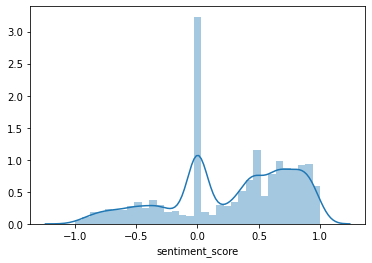

In [41]:
sns.distplot(df.sentiment_score)

The sentiment score above shows a wide range of sentiments for all the emojis. Hard to get any important insight from something this broad.

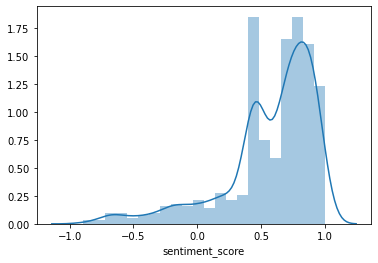

In [42]:
sns.distplot(df[df.top_emoji == '😂'].sentiment_score)

Inspecting the sentiment distribution of one of our top emojis shows that, to some degree, and emoji represents a certain sentiment, with some outliers that could be do to things like sarcasm etc.

### Important Note

See "selection biased" EDA notebook. Originally, I tried segmenting into more target classes based on data that was collected in a way that lent itself to selection bias.

Upon research into the subject matter, I found that studies have been done by various teams at various companies, with a notable one by instagram and another by Paul Ekman. Their research shows that, of all the emotions that emojis can represent, through NLP processing, the best way in which to segment different emotions is into 4 classes, discussed below.

Paul Ekman’s original theory about universal emotion categories suggests that human emotions can be categorized as one out of six different classes; anger, disgust,fearful, happy, sad and surprise. 

Furthermore, Instagram’s engineering team recently published a study based on 50 million English Instagram comments andcaptions from 2015 with a visualization of how emojis appear in similar contexts.

The resulting 2D semantic map indicates which emojis that can be considered as contextually similar. It can be concluded from the semantic map that emojis which could be considered a representations of the emotions ANGER, FEARFUL, HAPPY and SAD are clearly separated.

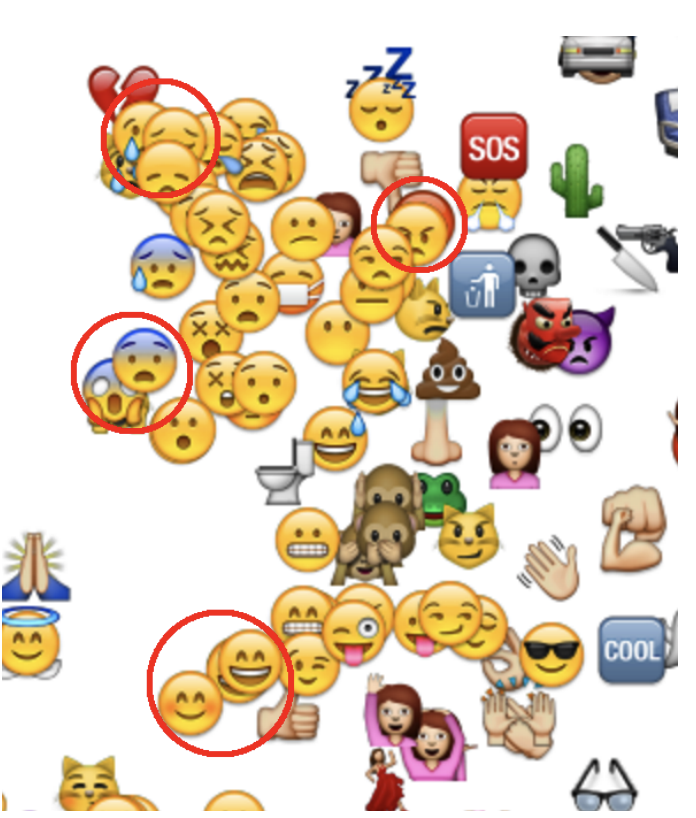

In [43]:
from IPython.display import Image
Image(filename='instagram_semantic_map.png', width=300)

One has to be careful not to read *too* much into this clustering representation since it is an attempt to produce a 2D space out of a 100D one. But it’s clear that semantics are being approximated in our representation. 

In [44]:
## Because of a lack of data, I am taking the liberty of grouping some extras into each category, but it still aligns
## with the mapping from instagram

sad = ['😭', '😩', '😢','😫','😓','😥','😟','🙁','😞'] ## removed '😔', since it had a postive sentiment
fearful = [ '😱','😳', '😰','😨']
angry = ['😡','😠','🤬','😤']
happy = ['😊','🤗','😁','😌','😀','🙂','😄']

In [45]:
print("Sentiments for sad")
for i in range(0,len(sad)):
    print(df[df.top_emoji==sad[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for fearful")
for i in range(0,len(fearful)):
    print(df[df.top_emoji==fearful[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for angry")
for i in range(0,len(angry)):
    print(df[df.top_emoji==angry[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for happy")
for i in range(0,len(happy)):
    print(df[df.top_emoji==happy[i]].sentiment_score.mean())


Sentiments for sad
-0.4377274193548384
-0.3062352941176469
-0.24089677419354844
-0.5734619047619047
-0.40635000000000004
-0.053066666666666686
-0.3465428571428571
-0.3753285714285714
-0.48549999999999993
----------------------
Sentiments for fearful
-0.6448744680851063
0.08104466019417475
-0.28213
-0.542475
----------------------
Sentiments for angry
-0.06775
-0.5824437499999999
-0.21382972972972975
0.08708
----------------------
Sentiments for happy
0.8181113475177302
0.656575
0.5428456521739127
0.5061823529411763
0.4197938775510205
0.5668681818181819
0.7559944444444446


In [46]:
all_e = sad + fearful + angry + happy

In [47]:
new_df = df[df.top_emoji.isin(all_e)]

In [48]:
conditions = [
    new_df.top_emoji.isin(sad[1:]),
    new_df.top_emoji.isin(fearful[1:]),
    new_df.top_emoji.isin(angry[1:]),
    new_df.top_emoji.isin(happy[1:])
    
]

choices = [
    sad[0],
    fearful[0],
    angry[0], 
    happy[0]
]

new_df.top_emoji = np.select(conditions, choices, default = new_df.top_emoji)

In [49]:
new_df.top_emoji.value_counts()

😭    524
😊    449
😱    164
😡    132
Name: top_emoji, dtype: int64

In [50]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))

In [51]:
new_df.drop('emoji_frequency', axis=1, inplace=True)
freq_map = dict(new_df.top_emoji.value_counts())
new_df['emoji_frequency'] = new_df.top_emoji.map(freq_map)

new_df.to_csv("tweets_4_classes.csv")


In [52]:
emojis = new_df.groupby('top_emoji').mean()
emojis.to_csv("emojis_NEW.csv")


In [53]:
emojis

,sentiment_score,emoji_frequency
top_emoji,,
😊,0.640257,449
😡,-0.141760,132
😭,-0.410020,524
😱,-0.164346,164


In [54]:
pics = ['happy.png','angry.png','cry.png', 'scary.png']

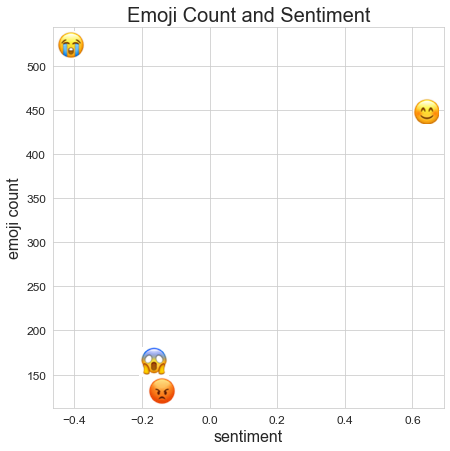

In [63]:
fig, ax = plt.subplots(figsize = (7,7))

sns.scatterplot(x=emojis.sentiment_score, y=emojis.emoji_frequency, ax=ax)
sns.set_style("whitegrid")
plt.xticks(fontsize=12)
plt.xlabel('sentiment', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('emoji count', fontsize=16)
plt.title("Emoji Count and Sentiment", fontsize = 20)

for x0, y0, pic in zip(emojis.sentiment_score, emojis.emoji_frequency,pics):
    ab = AnnotationBbox(getImage(pic), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.show()

From the above, it seems that, while only looking at sentiment score, it would be easy to determine a difference between happy, sad, and a third class. Sentiment score alone is not enough to distinguish fearful and angry.

However, NLP processing, especially the use of TF IDF, will likely find the differences.

It is also interesting to note the emoji counts for each. Data gathering for this project began a few days before the election (11/4) and continued for a few days after election day. It would be cool, in the future, to analyze the emoji usage count for the political tweet searches at a time months after the election.